# Get available credential

In [ ]:
import json

with open("/Users/ngdnhtien/.qiskit/qiskit-ibm.json", "r") as jF:
    credential = json.load(jF)

with open("/Users/ngdnhtien/.qiskit/bank.json", "r") as bank:
    credential_bank = json.load(bank)

credential_bank = {key: value for key, value in credential_bank.items() if value['capacity'] == "full"}
token_available = next(iter(credential_bank))

credential['default-ibm-quantum']['token'] = credential_bank[token_available]['token']

with open("/Users/ngdnhtien/.qiskit/qiskit-ibm.json", "w") as jF:
    json.dump(credential, jF)

# Contents

In this notebook, I do spectroscopy on qutrit.

In [2]:
import os
os.chdir('/Users/ngdnhtien/Research/Codespace/PulsatingPulseShop/')

# Necessary dependencies
import qiskit
import qiskit_ibm_provider
import utility as ut
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import json
import datetime

In [3]:
plt.rcParams['axes.linewidth'] = 1.1
%config InlineBackend.figure_formats = ['svg']
today = datetime.datetime.now()

In [7]:
provider = qiskit_ibm_provider.IBMProvider()
backend = provider.get_backend('ibm_brisbane')

qubit = 1
cbit = 0

num_qubits = int(qubit+1)
num_cbits = 1

weight = 1

rough_01_freq = backend.defaults().qubit_freq_est[qubit]
qubit_anharmonicty = backend.properties().qubits[qubit][3].value * 1e9
rough_12_freq = rough_01_freq + qubit_anharmonicty

print(r"f01 = "+f'{round(rough_01_freq/1e9, 4)}'+' GHz')
print(r'f12 = '+f'{round(rough_12_freq/1e9, 4)}'+' GHz')

f01 = 4.8151 GHz
f12 = 4.5054 GHz


# Round 1

In [8]:
backend_defaults = backend.defaults()
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]   
frequency_span_Hz = 50 * 1e6
frequency_step_Hz = 1 * 1e6

# 25 each side
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2

frequencies_GHz = np.arange(frequency_min / 1e9, 
                            frequency_max / 1e9, 
                            frequency_step_Hz / 1e9)
  
drive_amp = 0.3
freq = qiskit.circuit.Parameter('freq')
with qiskit.pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.set_frequency(freq, drive_chan)
    qiskit.pulse.play(qiskit.pulse.Gaussian(duration=32,
                              sigma=8,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)
    
sweep_gate = qiskit.circuit.Gate("sweep", 1, [freq])

qc_sweep = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
qc_sweep.append(sweep_gate, [qubit])
qc_sweep.measure(qubit, cbit)
qc_sweep.add_calibration(sweep_gate, [qubit], sweep_sched, [freq])

frequencies_Hz = frequencies_GHz * 1e9
exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]


In [31]:
num_shots_per_frequency = 2048

job = backend.run(exp_sweep_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)

print(job.job_id())

csc0qvqdape00085tcgg


In [36]:
print(job.status())

JobStatus.DONE


In [37]:
job = provider.backend.retrieve_job('csc0qvqdape00085tcgg')
exp = ut.DataAnalysis(experiment=job, average=True, shots=num_shots_per_frequency, qubit=0)
exp.retrieve_data(average=True)

with open("./characterization/spectroscopy01/data/round1.pkl", "wb") as f:
    pickle.dump(exp.IQ_data, f)

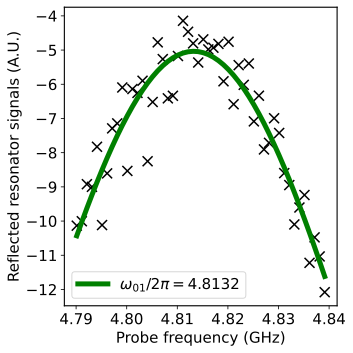

In [44]:
IQdata_round1 = np.load("./characterization/spectroscopy01/data/round1.pkl", allow_pickle=True)

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
popt, yfit, pcov = ut.fit_function(frequencies_GHz,
                                 np.real(IQdata_round1), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [10, 4.8, 1, -4-10] # initial parameters for curve_fit
                                )
ax.scatter(frequencies_GHz, IQdata_round1, marker='x', color='black', s=100)
# ax.axvline(np.round(popt[1]/2,3), linestyle='--', label=r'$\tilde{\Omega}_0=$'+f'{np.round(popt[1]/2,3)}')
ax.plot(frequencies_GHz, yfit, linewidth=5, color='green', label=r'$\omega_{01}/2\pi=$'+f'{np.round(popt[1],4)}')

ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=15)
ax.set_ylabel('Reflected resonator signals (A.U.)', fontsize=15)
ax.set_xlabel('Probe frequency (GHz)', fontsize=15)
fig.tight_layout()
fig.savefig('./characterization/spectroscopy01/figs/spec01_shortpulse.png', dpi=600)

# Round 2

In [43]:
backend_defaults = backend.defaults()
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]   
frequency_span_Hz = 50 * 1e6
frequency_step_Hz = 1 * 1e6

# 25 each side
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2

frequencies_GHz = np.arange(frequency_min / 1e9, 
                            frequency_max / 1e9, 
                            frequency_step_Hz / 1e9)
  
drive_amp = 0.1
freq = qiskit.circuit.Parameter('freq')
with qiskit.pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.set_frequency(freq, drive_chan)
    qiskit.pulse.play(qiskit.pulse.Gaussian(duration=120,
                              sigma=30,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)
    
sweep_gate = qiskit.circuit.Gate("sweep", 1, [freq])

qc_sweep = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
qc_sweep.append(sweep_gate, [qubit])
qc_sweep.measure(qubit, cbit)
qc_sweep.add_calibration(sweep_gate, [qubit], sweep_sched, [freq])

frequencies_Hz = frequencies_GHz * 1e9
exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

In [44]:
num_shots_per_frequency = 2048

job = backend.run(exp_sweep_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)

print(job.job_id())

csc7d34x35wg0080zb7g


In [48]:
job = provider.backend.retrieve_job('csc7d34x35wg0080zb7g')
exp = ut.DataAnalysis(experiment=job, average=True, shots=num_shots_per_frequency, qubit=0)
exp.retrieve_data(average=True)

with open("./characterization/spectroscopy01/data/round2.pkl", "wb") as f:
    pickle.dump(exp.IQ_data, f)

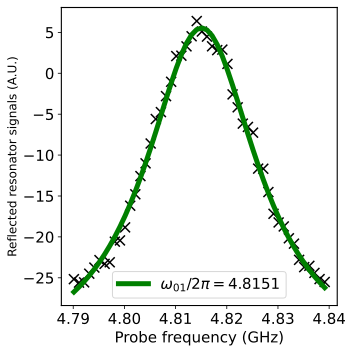

In [45]:
IQdata_round2 = np.load("./characterization/spectroscopy01/data/round2.pkl", allow_pickle=True)

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
popt, yfit, pcov = ut.fit_function(frequencies_GHz,
                                 np.real(IQdata_round2), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [10, 4.8, 1, -4-10] # initial parameters for curve_fit
                                )
ax.scatter(frequencies_GHz, IQdata_round2, marker='x', color='black', s=100)
# ax.axvline(np.round(popt[1]/2,3), linestyle='--', label=r'$\tilde{\Omega}_0=$'+f'{np.round(popt[1]/2,3)}')
ax.plot(frequencies_GHz, yfit, linewidth=5, color='green', label=r'$\omega_{01}/2\pi=$'+f'{np.round(popt[1],4)}')

ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=15)
ax.set_ylabel('Reflected resonator signals (A.U.)', fontsize=12)
ax.set_xlabel('Probe frequency (GHz)', fontsize=15)
fig.tight_layout()
fig.savefig('./characterization/spectroscopy01/figs/spec01_longpulse.png', dpi=600)